In [1]:
import argparse
import geopandas as gpd
import numpy as np
import pickle
from functools import partial
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from gerrychain import constraints
from gerrychain.tree import recursive_tree_part
from gingleator import Gingleator
# from little_helpers import *
import json

# BURST_LEN = args.l
# NUM_DISTRICTS = num_h_districts[args.state]
# ITERS = args.iters
# POP_COL = "TOTPOP"
# N_SAMPS = 10
# SCORE_FUNCT = None #score_functs[args.score]
# EPS = 0.045
# MIN_POP_COL = args.col

/Users/shelger/miniconda3/envs/langchain/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
la_graph = Graph.from_file("./shapefiles/la_election_shapefile.shp")

In [3]:
print(la_graph.nodes()[0])
cds = {node: la_graph.nodes[node]['CD'] for node in la_graph.nodes()}
unique_values = set(cds.values())
print(unique_values)

{'boundary_node': False, 'area': 35328069.63942626, 'STATEFP': '22', 'COUNTYFP': '001', 'VTDST': '0001-1', 'NAME': '1-1', 'G20PRER': 1050, 'G20PRED': 81, 'G20USSDPER': 28, 'G20USSDEDW': 25, 'G20USSDPIE': 4, 'G20USSDKNI': 5, 'G20USSDWEN': 0, 'G20USSLSIG': 0, 'G20USSIMEN': 3, 'G20USSOPRI': 2, 'G20USSOJOH': 4, 'G20USSNBIL': 10, 'G20USSNBOU': 18, 'G20USSNMON': 3, 'G20USSNDAR': 3, 'TOTPOP': 2125, 'HISP': 87, 'NH_WHITE': 1880, 'NH_BLACK': 95, 'NH_AMIN': 0, 'NH_ASIAN': 4, 'NH_NHPI': 0, 'NH_OTHER': 4, 'NH_2MORE': 55, 'CD': 3, 'G20USSR': 1021, 'G20USSD': 62, 'geometry': <POLYGON ((5.71e+05 3.35e+06, 5.71e+05 3.35e+06, 5.71e+05 3.35e+06, 5.71e+05...>}
{1, 2, 3, 4, 5, 6}


In [17]:
my_updaters = {
    "population": Tally("TOTPOP", alias="population"),
    "NH_BLACK": Tally("NH_BLACK"),
    "cut_edges": cut_edges,        
}

total_pop = sum([la_graph.nodes()[n]["TOTPOP"] for n in la_graph.nodes()])
print(total_pop)

4657757


In [22]:
assignment = {node: la_graph.nodes[node]['CD'] for node in la_graph.nodes()}
init_partition = Partition(la_graph, assignment=assignment, updaters=my_updaters)

In [26]:
ITERS = 100
BURST_LEN = 10
N_SAMPS = 10
num_bursts = int(ITERS/BURST_LEN)

gingles = Gingleator(init_partition, pop_col="TOTPOP",
             threshold=0.1, score_funct=None, epsilon=0.05,
             minority_perc_col="NH_BLACK_perc")
gingles.init_minority_perc_col("NH_BLACK", "population", "NH_BLACK_perc")

In [27]:
def short_burst_runner():
    for threshold in np.arange(0.1, 1.0, 0.1):
        gingles.threshold = threshold
        print("Starting Short Bursts Runs", flush=True)
        for n in range(N_SAMPS):
            sb_obs = gingles.short_burst_run(num_bursts=num_bursts, num_steps=BURST_LEN,
                                             maximize=True, verbose=False)
            print("\tFinished chain {}".format(n), flush=True)
            print("\tSaving results", flush=True)
            f_out = f"./saved_data/la_result_{threshold:.1f}_{n}.npy"
            np.save(f_out, sb_obs[1])
            f_out_part = f"./saved_data/la_result_{threshold:.1f}_{n}.p"
            max_stats = {"black_population": sb_obs[0][0]["NH_BLACK"],}
            with open(f_out_part, "wb") as f_out:
                pickle.dump(max_stats, f_out)

In [28]:
short_burst_runner()

Starting Short Bursts Runs
	Finished chain 0
	Saving results
	Finished chain 1
	Saving results
	Finished chain 2
	Saving results
	Finished chain 3
	Saving results
	Finished chain 4
	Saving results
	Finished chain 5
	Saving results
	Finished chain 6
	Saving results
	Finished chain 7
	Saving results
	Finished chain 8
	Saving results
	Finished chain 9
	Saving results
Starting Short Bursts Runs
	Finished chain 0
	Saving results
	Finished chain 1
	Saving results
	Finished chain 2
	Saving results
	Finished chain 3
	Saving results
	Finished chain 4
	Saving results
	Finished chain 5
	Saving results
	Finished chain 6
	Saving results
	Finished chain 7
	Saving results
	Finished chain 8
	Saving results
	Finished chain 9
	Saving results
Starting Short Bursts Runs
	Finished chain 0
	Saving results
	Finished chain 1
	Saving results
	Finished chain 2
	Saving results
	Finished chain 3
	Saving results
	Finished chain 4
	Saving results
	Finished chain 5
	Saving results
	Finished chain 6
	Saving results
	

In [52]:
la_data = np.load('saved_data/la_result_0.5_5.npy')
y_values = []
for i in range(1, 10):
    largest_element = 0
    for j in range(0, 9):
        la_data = np.load(f"./saved_data/la_result_0.{i}_{j}.npy")
        largest_row_element = np.max(la_data)
        if largest_row_element > largest_element:
            largest_element = largest_row_element
    y_values.append(largest_element)
# print("Shape of la_data:", la_data.shape)
print(y_values)

[6.0, 6.0, 5.0, 2.0, 1.0, 0, 0, 0, 0]


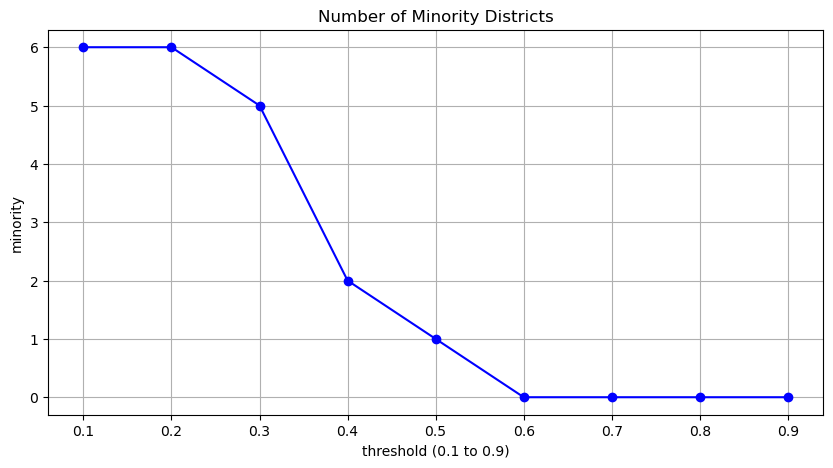

In [55]:
import matplotlib.pyplot as plt
x_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.title('Number of Minority Districts')
plt.xlabel('threshold (0.1 to 0.9)')
plt.ylabel('minority')
plt.grid(True)
plt.xticks(x_values)
plt.show()

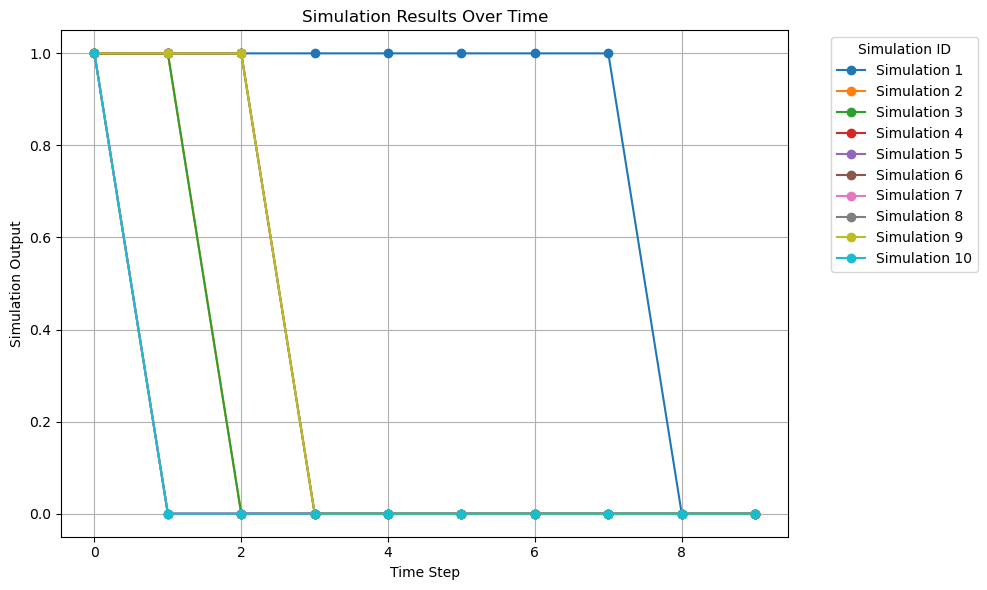

In [32]:
# import pickle
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# df = pd.DataFrame(la_data)

# df = df.T
# df.columns = [f"Simulation {i+1}" for i in range(df.shape[1])]
# plt.figure(figsize=(10, 6))
# for column in df.columns:
#     plt.plot(df.index, df[column], marker='o', label=column)


# plt.title('Simulation Results Over Time')
# plt.xlabel('Time Step')
# plt.ylabel('Simulation Output')
# plt.legend(title='Simulation ID', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()